In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
import skimage
print(skimage.__version__)

0.17.2


In [5]:
import skimage.color
import skimage.io
import skimage.feature
import skimage.transform

In [6]:
## load the data

In [8]:
data=pickle.load(open('data_animals.pickle','rb'))
data['description']

'There are 20 classes of images where each image are of 80x80 dim and there are total of 2023 instances'

In [9]:
## split the data into independent and dependent set

In [10]:
X = data['data']
y = data['labels']

In [13]:
type(data)

dict

In [14]:
## split the data into train and test set

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify=y)

In [16]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((1618, 80, 80, 3), (405, 80, 80, 3), 1618, 405)

### Feature Extraction

### HOG (Histogram Oriented Gradient)

# reading the image

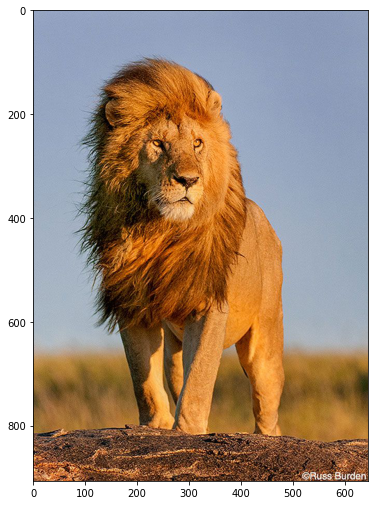

In [47]:
img = skimage.io.imread('lion.bmp')
plt.figure(figsize=(6,10))
plt.imshow(img)

In [48]:
# convert image to grayscale

img_rescale = skimage.transform.rescale(img,1/3).reshape((302, 215))

gray = skimage.color.rgb2gray(img_rescale)


feature_vector, hog_img = skimage.feature.hog(gray,orientations=9,pixels_per_cell=(14,14),cells_per_block=(2,2),
                   visualize=True)

/Users/paras/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


In [49]:
img_rescale = skimage.transform.rescale(img,1/3)
img_rescale.shape

(302, 215, 1)

In [50]:
len(feature_vector)

10080

In [51]:
img.shape

(907, 645, 3)

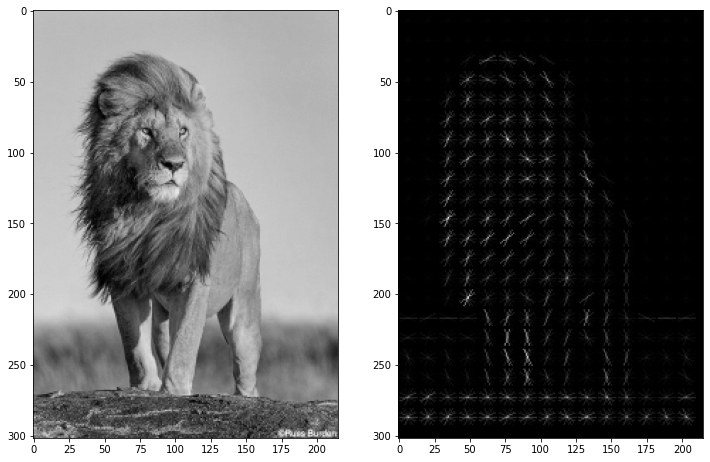

In [52]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(gray,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hog_img,cmap='gray')

## Preprocessing 

#### 1.RGB TO GRAYSCALE
#### 2.HOG

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

In [54]:
class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])

In [55]:
X_train.shape

(1618, 80, 80, 3)

In [56]:
rgb2gray_obj=rgb2gray_transform()
X_train_gray=rgb2gray_obj.fit_transform(X_train)

In [57]:
X_train_gray.shape

(1618, 80, 80)

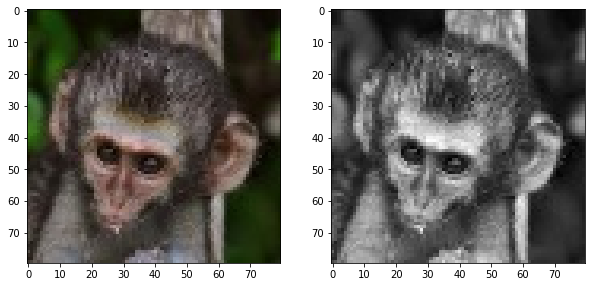

In [58]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(X_train[0])
plt.subplot(1,2,2)
plt.imshow(X_train_gray[0],cmap='gray')

In [60]:
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8,8),cells_per_block=(3, 3)):
        self.orientations=orientations
        self.pixels_per_cell=pixels_per_cell
        self.cells_per_block=cells_per_block
    
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,
                               orientations=self.orientations,
                               pixels_per_cell=self.pixels_per_cell,
                               cells_per_block=self.cells_per_block)
            return hog_features
        
        features = np.array([local_hog(x) for x in X])
#         hog_images= np.array([local_hog(x) for x in X])
        return features
        

In [61]:
# convert all grayscale images into hog images
hogt = hogtransformer()

In [62]:
X_train_hog=hogt.fit_transform(X_train_gray)

In [63]:
X_train_hog.shape

(1618, 5184)

### Training Machine Learning Model

In [65]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

In [66]:
model_sgd = SGDClassifier(loss='hinge',learning_rate='adaptive',early_stopping=True,eta0=0.1)

In [67]:
## pipeline 

X_train.shape, X_test.shape

((1618, 80, 80, 3), (405, 80, 80, 3))

In [68]:
grayify = rgb2gray_transform()
hog_t = hogtransformer()
sc = StandardScaler()

In [69]:
## pipeline

## step1: convert to grayscale
X_train_gray = grayify.fit_transform(X_train)
## step2: extract features
X_train_hog=hog_t.fit_transform(X_train_gray)
## step3: perform normalization
X_train_scaled = sc.fit_transform(X_train_hog)
## step4: machine learning model
model_sgd.fit(X_train_scaled,y_train)

SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='adaptive')

In [70]:
## step1: convert to grayscale
X_test_gray = grayify.fit_transform(X_test)
## step2: extract features
X_test_hog=hog_t.fit_transform(X_test_gray)
## step3: perform normalization
X_test_scaled = sc.transform(X_test_hog)

y_pred = model_sgd.predict(X_test_scaled)

## model evaluation

In [71]:
metrics.accuracy_score(y_test,y_pred)

0.5135802469135803

In [72]:
cr=metrics.classification_report(y_test,y_pred,output_dict=True)

In [73]:
pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.533333,0.400000,0.457143,20.00000
cat,0.522727,0.718750,0.605263,32.00000
chicken,0.642857,0.450000,0.529412,20.00000
cow,0.400000,0.300000,0.342857,20.00000
deer,0.611111,0.550000,0.578947,20.00000
dog,0.307692,0.296296,0.301887,27.00000
duck,0.666667,0.600000,0.631579,20.00000
eagle,0.400000,0.210526,0.275862,19.00000
elephant,0.578947,0.550000,0.564103,20.00000
human,0.600000,0.900000,0.720000,20.00000


In [74]:
# if >0.5 it is a good model
metrics.cohen_kappa_score(y_test,y_pred)

0.4857026828419302

In [75]:
### Pipelining the Model

In [76]:
from sklearn.pipeline import Pipeline

In [77]:
model_pipe = Pipeline([
    ('grayscale',rgb2gray_transform()),
    ('hog_transform',hogtransformer(orientations=8,pixels_per_cell=(10,10),cells_per_block=(3,3))),
    ('scaler',StandardScaler()),
    ('model_sgd',SGDClassifier(loss='hinge',learning_rate='adaptive',early_stopping=True,eta0=0.1))
])

In [78]:
model_pipe.fit(X_train,y_train)

Pipeline(steps=[('grayscale', rgb2gray_transform()),
                ('hog_transform',
                 hogtransformer(orientations=8, pixels_per_cell=(10, 10))),
                ('scaler', StandardScaler()),
                ('model_sgd',
                 SGDClassifier(early_stopping=True, eta0=0.1,
                               learning_rate='adaptive'))])

In [79]:
y_pred =model_pipe.predict(X_test)

In [80]:
y_pred

array(['eagle', 'eagle', 'panda', 'duck', 'rabbit', 'cat', 'mouse',
       'mouse', 'bear', 'duck', 'elephant', 'sheep', 'cat', 'rabbit',
       'wolf', 'monkey', 'rabbit', 'rabbit', 'cat', 'bear', 'sheep',
       'mouse', 'duck', 'wolf', 'tiger', 'tiger', 'deer', 'rabbit',
       'sheep', 'deer', 'monkey', 'rabbit', 'monkey', 'duck', 'cow',
       'pigeon', 'cat', 'sheep', 'chicken', 'wolf', 'human', 'panda',
       'human', 'lion', 'elephant', 'wolf', 'human', 'rabbit', 'wolf',
       'elephant', 'tiger', 'dog', 'wolf', 'panda', 'duck', 'dog',
       'human', 'lion', 'deer', 'elephant', 'tiger', 'mouse', 'panda',
       'cow', 'deer', 'dog', 'bear', 'cow', 'duck', 'tiger', 'panda',
       'elephant', 'rabbit', 'tiger', 'cow', 'chicken', 'human', 'mouse',
       'dog', 'chicken', 'cat', 'rabbit', 'human', 'pigeon', 'sheep',
       'duck', 'rabbit', 'eagle', 'deer', 'deer', 'panda', 'wolf',
       'panda', 'wolf', 'monkey', 'duck', 'elephant', 'dog', 'pigeon',
       'monkey', 'elephan

In [81]:
## evaluation

cr=pd.DataFrame(metrics.classification_report(y_test,y_pred,output_dict=True)).T
cr

,precision,recall,f1-score,support
bear,0.500000,0.400000,0.444444,20.000000
cat,0.642857,0.562500,0.600000,32.000000
chicken,0.444444,0.400000,0.421053,20.000000
cow,0.421053,0.400000,0.410256,20.000000
deer,0.714286,0.750000,0.731707,20.000000
dog,0.526316,0.370370,0.434783,27.000000
duck,0.555556,0.750000,0.638298,20.000000
eagle,0.526316,0.526316,0.526316,19.000000
elephant,0.454545,0.750000,0.566038,20.000000
human,0.782609,0.900000,0.837209,20.000000


In [82]:
# if >0.5 it is a good model
metrics.cohen_kappa_score(y_test,y_pred)

0.5203398558187435

In [83]:
### Grid-search for hyperparameter tuning

In [84]:
from sklearn.model_selection import GridSearchCV #FOR HYPERPARAMETER TUNING


In [85]:
base_estimator = Pipeline([
    ('grayscale',rgb2gray_transform()),
    ('hog_transform',hogtransformer()),
    ('scaler',StandardScaler()),
    ('model_sgd',SGDClassifier())
])

In [86]:
## parameters we need to tune

''' got error while including this in param_grid 
    
    {
        'hog_transform__orientations':[9,10],
        'hog_transform__pixels_per_cell':[(7,7),(8,8)],
        'hog_transform__cells_per_block':[(2,2),(3,3)],
        'model_sgd__loss':['hinge','squared_hinge'],
        'model_sgd__learning_rate':['adaptive'],
        'model_sgd__eta0': [0.0001,0.001]
    }
    '''

param_grid = [
    {
        'hog_transform__orientations':[9,10],
        'hog_transform__pixels_per_cell':[(7,7),(8,8)],
        'hog_transform__cells_per_block':[(2,2),(3,3)],
        'model_sgd__loss':['hinge','squared_hinge'],
        'model_sgd__learning_rate':['optimal'],
    }]

In [87]:
model_grid = GridSearchCV(estimator=base_estimator,param_grid=param_grid, scoring='accuracy',n_jobs=1,
                         cv=3,verbose=2)

In [88]:
model_grid.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(7, 7), model_sgd__learning_rate=optimal, model_sgd__loss=hinge; total time=   8.7s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(7, 7), model_sgd__learning_rate=optimal, model_sgd__loss=hinge; total time=   9.0s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(7, 7), model_sgd__learning_rate=optimal, model_sgd__loss=hinge; total time=  10.2s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(7, 7), model_sgd__learning_rate=optimal, model_sgd__loss=squared_hinge; total time=  17.1s
[CV] END hog_transform__cells_per_block=(2, 2), hog_transform__orientations=9, hog_transform__pixels_per_cell=(7, 7), model_sgd__learning_rate=optimal, mod

[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), model_sgd__learning_rate=optimal, model_sgd__loss=hinge; total time=   8.6s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), model_sgd__learning_rate=optimal, model_sgd__loss=hinge; total time=   8.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), model_sgd__learning_rate=optimal, model_sgd__loss=hinge; total time=   7.9s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), model_sgd__learning_rate=optimal, model_sgd__loss=squared_hinge; total time=   7.8s
[CV] END hog_transform__cells_per_block=(3, 3), hog_transform__orientations=10, hog_transform__pixels_per_cell=(8, 8), model_sgd__learning_rate=optimal, model_sgd__loss=squared_hinge; total time=   7.8s
[CV] END 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('grayscale', rgb2gray_transform()),
                                       ('hog_transform', hogtransformer()),
                                       ('scaler', StandardScaler()),
                                       ('model_sgd', SGDClassifier())]),
             n_jobs=1,
             param_grid=[{'hog_transform__cells_per_block': [(2, 2), (3, 3)],
                          'hog_transform__orientations': [9, 10],
                          'hog_transform__pixels_per_cell': [(7, 7), (8, 8)],
                          'model_sgd__learning_rate': ['optimal'],
                          'model_sgd__loss': ['hinge', 'squared_hinge']}],
             scoring='accuracy', verbose=2)

In [89]:
model_grid.best_params_

{'hog_transform__cells_per_block': (2, 2),
 'hog_transform__orientations': 9,
 'hog_transform__pixels_per_cell': (8, 8),
 'model_sgd__learning_rate': 'optimal',
 'model_sgd__loss': 'squared_hinge'}

In [90]:
model_grid.best_score_

0.7373508325889279

In [91]:
model_best = model_grid.best_estimator_

In [92]:
model_best

Pipeline(steps=[('grayscale', rgb2gray_transform()),
                ('hog_transform', hogtransformer(cells_per_block=(2, 2))),
                ('scaler', StandardScaler()),
                ('model_sgd', SGDClassifier(loss='squared_hinge'))])

In [93]:
model_best.get_params()

{'memory': None,
 'steps': [('grayscale', rgb2gray_transform()),
  ('hog_transform', hogtransformer(cells_per_block=(2, 2))),
  ('scaler', StandardScaler()),
  ('model_sgd', SGDClassifier(loss='squared_hinge'))],
 'verbose': False,
 'grayscale': rgb2gray_transform(),
 'hog_transform': hogtransformer(cells_per_block=(2, 2)),
 'scaler': StandardScaler(),
 'model_sgd': SGDClassifier(loss='squared_hinge'),
 'hog_transform__cells_per_block': (2, 2),
 'hog_transform__orientations': 9,
 'hog_transform__pixels_per_cell': (8, 8),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model_sgd__alpha': 0.0001,
 'model_sgd__average': False,
 'model_sgd__class_weight': None,
 'model_sgd__early_stopping': False,
 'model_sgd__epsilon': 0.1,
 'model_sgd__eta0': 0.0,
 'model_sgd__fit_intercept': True,
 'model_sgd__l1_ratio': 0.15,
 'model_sgd__learning_rate': 'optimal',
 'model_sgd__loss': 'squared_hinge',
 'model_sgd__max_iter': 1000,
 'model_sgd__n_iter_no_change': 5,
 'mod

In [94]:
y_pred = model_best.predict(X_test)

In [95]:
cr = pd.DataFrame(metrics.classification_report(y_test,y_pred,output_dict=True)).T
cr

/Users/paras/opt/anaconda3/envs/imgenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paras/opt/anaconda3/envs/imgenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paras/opt/anaconda3/envs/imgenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

,precision,recall,f1-score,support
bear,0.652174,0.750000,0.697674,20.000000
cat,0.800000,0.875000,0.835821,32.000000
chicken,0.875000,0.700000,0.777778,20.000000
cow,0.576923,0.750000,0.652174,20.000000
deer,0.818182,0.900000,0.857143,20.000000
dog,0.416667,0.370370,0.392157,27.000000
duck,0.727273,0.800000,0.761905,20.000000
eagle,0.478261,0.578947,0.523810,19.000000
elephant,0.681818,0.750000,0.714286,20.000000
human,0.950000,0.950000,0.950000,20.000000


In [96]:
with open('best_model.pickle', 'wb') as f:
    pickle.dump(model_best, f)

In [97]:
from sklearn.pipeline import make_pipeline

In [98]:
pipeline1 = make_pipeline(rgb2gray_transform(),
                         hogtransformer(orientations=10,
                                       pixels_per_cell=(8,8),
                                        cells_per_block=(3,3)
                                       ))

In [99]:
feature_vector = pipeline1.fit_transform(X_train)

## applying standard scaler

In [100]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(feature_vector)

In [101]:
model = SGDClassifier(learning_rate='optimal',loss='squared_hinge',alpha=0.01, early_stopping=True)

In [102]:
model.fit(X_train_scaled,y_train)

SGDClassifier(alpha=0.01, early_stopping=True, loss='squared_hinge')

## evaluate model

In [103]:
f_v = pipeline1.fit_transform(X_test)
transformed_x = scaler.transform(f_v)
y_pred = model.predict(transformed_x)

In [104]:
cr=pd.DataFrame(metrics.classification_report(y_test,y_pred,output_dict=True)).T

/Users/paras/opt/anaconda3/envs/imgenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paras/opt/anaconda3/envs/imgenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/paras/opt/anaconda3/envs/imgenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [105]:
cr

,precision,recall,f1-score,support
bear,0.608696,0.700000,0.651163,20.000000
cat,0.783784,0.906250,0.840580,32.000000
chicken,0.833333,0.750000,0.789474,20.000000
cow,0.631579,0.600000,0.615385,20.000000
deer,0.875000,0.700000,0.777778,20.000000
dog,0.478261,0.407407,0.440000,27.000000
duck,0.592593,0.800000,0.680851,20.000000
eagle,0.578947,0.578947,0.578947,19.000000
elephant,0.850000,0.850000,0.850000,20.000000
human,0.894737,0.850000,0.871795,20.000000


### save the model

In [106]:
pickle.dump(model,open('image_classification_sgd.pickle','wb'))

In [107]:
pickle.dump(scaler,open('dsa_scaler.pickle','wb'))